<a href="https://colab.research.google.com/github/AAI-520/AAI_520_Gen_Chatbot_Final_Project/blob/svaddi/AAI_520_Gen_Chatbot_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

**About the project:**

In today's digital age, businesses face a growing demand for efficient and responsive customer support services. Chatbots have emerged as a valuable solution to address this need by providing real-time assistance to customers and users. This document outlines the business understanding behind building a chatbot for conversational support.

**Author(s):**

Jamileh Jahangiry

Kobe Mensah

Shas Vaddi


### **I. Business Understanding**

Business Goals
The primary goals of developing a chatbot for conversational support are:

**Enhanced Customer Experience**

Improve the overall customer experience by offering timely and helpful responses to customer inquiries, thereby increasing satisfaction and loyalty.

**Cost Efficiency**

To reduce operational costs associated with customer support by automating routine tasks and providing 24/7 availability.

**Scalability**

To handle a growing volume of customer inquiries without the need for a proportional increase in support staff.

**Data Collection**

To gather valuable insights from customer interactions, which can inform business decisions and enhance products or services.

#### **Key Features:**

To meet the goals outlined above, the chatbot will possess the following key features:

**Natural Language Understanding**

The chatbot will be capable of understanding and processing natural language queries and responses.

**Multi-Turn Conversations**

The ability to handle multi-turn conversations, maintaining context across interactions for a seamless user experience.

**Adaptive Learning**

Continuous learning and adaptation to user queries and feedback, improving accuracy and relevance over time.

**Integration**

Integration with existing business systems, databases, and knowledge bases to provide up-to-date information.

**Personalization**

Providing personalized responses and recommendations based on user profiles and historical interactions.



In [1]:
#@title Import all required libraries

import torch.nn as nn
!pip install transformers
import numpy as np
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from math import exp
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
from collections import defaultdict

In [2]:
#@title  Mount Google Drive & Load Data
# Mount the drive
drive.mount('/content/drive')

# Load the dataset
with open('/content/drive/MyDrive/train-v1.1.json', 'r') as f:
    dataset = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title Extract Relevant data
relevant_data = []

for item in dataset['data']:
    for paragraph in item['paragraphs']:
        for qa in paragraph['qas']:
            question = qa['question']
            answers = [answer['text'] for answer in qa['answers']]
            context = paragraph['context']

            # Create a dictionary to store the relevant data
            data_point = {
                'question': question,
                'answers': answers,
                'context': context
            }
            relevant_data.append(data_point)




### **II.Data Understanding**
In this phase, we will gain a deep understanding of the data used in the project. This includes understanding the data's format, structure, content, and quality. It is essential to thoroughly understand the data before proceeding to the subsequent phases. This is because the quality of the data will significantly impact the project's success.

Specifically, the data understanding phase involves the following tasks:
Collecting the data: This consists in identifying and obtaining the data sources.

**Describing the data**
This involves documenting the data's format, structure, content, and quality.

**Exploring the data**
This involves using data visualization techniques to analyze and understand the data's characteristics.

**Identifying data quality issues**
This involves identifying any problems with the data, such as missing values, outliers, or errors.

Some of the benefits of doing a thorough data understanding include:

**Reduced risk of project failure**
By understanding the data, the data scientist can identify any potential problems and take steps to mitigate the risk of project failure.

**Improved modeling results**
By understanding the data, the data scientist can select the proper modeling techniques and tune the models to achieve better results.

**Increased business value**
By understanding the data, the data scientist can identify new opportunities to create business value.


In [4]:
# Print the number of data points
num_data_points = len(relevant_data)
print(f"Number of data points: {num_data_points}")

# Create a DataFrame for easier data manipulation and analysis
df = pd.DataFrame(relevant_data)


Number of data points: 87599


In [5]:
df.head(200)

,question,answers,context
0,To whom did the Virgin Mary allegedly appear i...,[Saint Bernadette Soubirous],"Architecturally, the school has a Catholic cha..."
1,What is in front of the Notre Dame Main Building?,[a copper statue of Christ],"Architecturally, the school has a Catholic cha..."
2,The Basilica of the Sacred heart at Notre Dame...,[the Main Building],"Architecturally, the school has a Catholic cha..."
3,What is the Grotto at Notre Dame?,[a Marian place of prayer and reflection],"Architecturally, the school has a Catholic cha..."
4,What sits on top of the Main Building at Notre...,[a golden statue of the Virgin Mary],"Architecturally, the school has a Catholic cha..."
...,...,...,...
195,Where among US universities does Notre Dame rank?,[among the top twenty],"Besides its prominence in sports, Notre Dame i..."
196,How many individual colleges are part of Notre...,[four],"Besides its prominence in sports, Notre Dame i..."
197,Which prize does the Architecture School at No...,[Driehaus Architecture Prize],"Besides its prominence in sports, Notre Dame i..."
198,How many doctorate and masters programs are av...,[more than 50],"Besides its prominence in sports, Notre Dame i..."


In [6]:
#@title Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:", missing_values)

Missing Values: question    0
answers     0
context     0
dtype: int64


In [7]:
# shape of the data
print('Training Features shape: ', df.shape)

Training Features shape:  (87599, 3)


In [8]:
# Obtain general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  87599 non-null  object
 1   answers   87599 non-null  object
 2   context   87599 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [9]:
#@title Number of Questions
num_questions = len(df)
print(f'Number of Questions: {num_questions}')

Number of Questions: 87599


# ***Exploratory Data Analysis (EDA)***

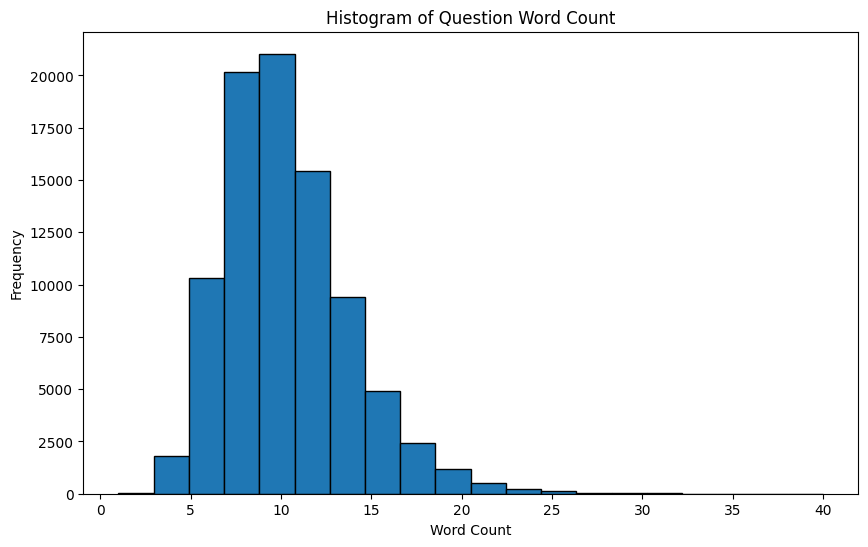

In [10]:
#@title Histogram of Question Word Count
question_word_counts = df['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(question_word_counts, bins=20, edgecolor='k')
plt.title("Histogram of Question Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

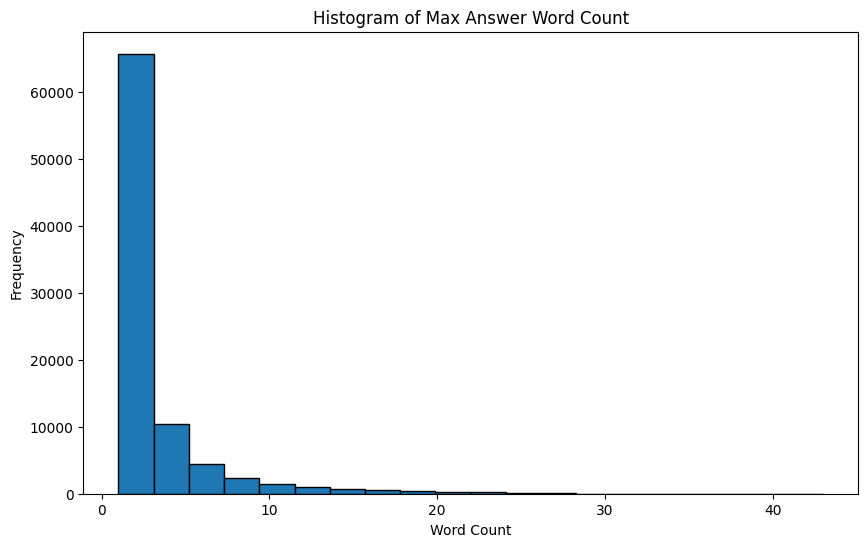

In [11]:
#@title Distribution of Answer Lengths
answer_word_counts = df['answers'].apply(lambda x: [len(answer.split()) for answer in x])
max_answer_word_counts = answer_word_counts.apply(max)
plt.figure(figsize=(10, 6))
plt.hist(max_answer_word_counts, bins=20, edgecolor='k')
plt.title("Histogram of Max Answer Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

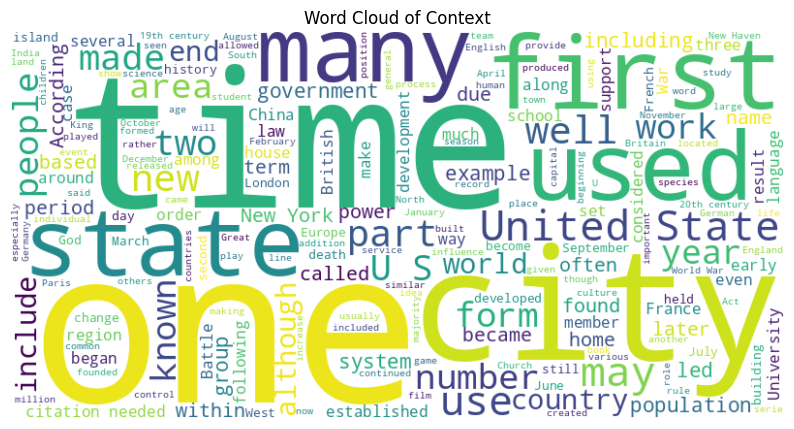

In [12]:
#@title Word Cloud of Context
from wordcloud import WordCloud
context_words = ' '.join(df['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(context_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Context')
plt.axis('off')
plt.show()

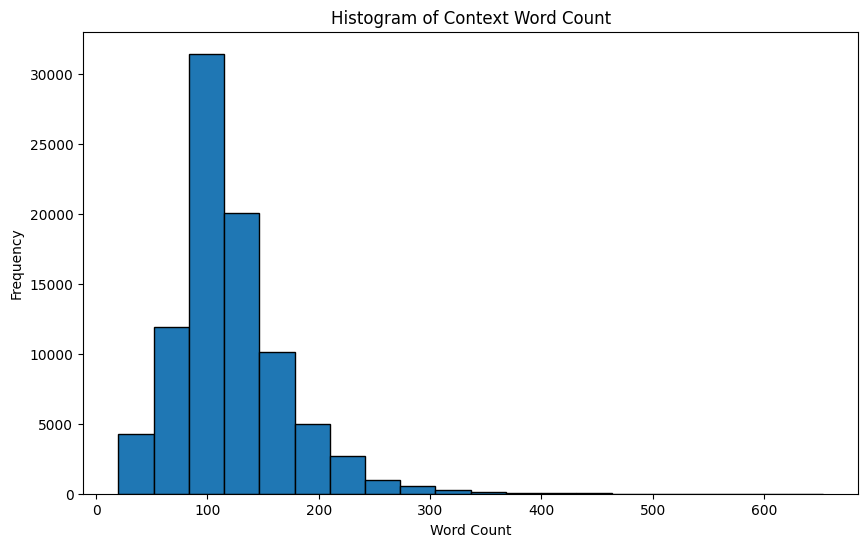

In [13]:
# Distribution of Context Lengths
context_word_counts = df['context'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(context_word_counts, bins=20, edgecolor='k')
plt.title('Histogram of Context Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### **III.Data Preparation**

The data preparation phase is often the most time-consuming phase of a data mining project but is also one of the most important. By taking the time to prepare the data properly, we can improve the chances of success for the project. In this data preparation phase, we will explore various methods (as and if required) clean, format, and integrate the data so that it is ready for modeling. This includes tasks such as:

**Cleaning the data**
This involves removing errors, outliers, and missing values from the data.

**Formatting the data**
This involves ensuring the data is in the correct format for the modeling techniques.

**Integrating the data**
This involves combining different data sources into a single dataset.
The data preparation phase is typically the third phase of the CRISP-DM framework, and it is essential to thoroughly prepare the data before moving on to the modeling phase. This is because the quality of the data will have a significant impact on the accuracy of the models.

**Data sampling**
This involves selecting a subset of the data for modeling, which can be used to reduce the dataset's size or improve the modeling algorithms' performance.

**Data validation**
This involves checking the data for errors and ensuring that it is ready for modeling.


In [14]:
# Convert answers to lowercase
for data_point in relevant_data:
    data_point['answers'] = [answer.lower() for answer in data_point['answers']]

# Calculate true maximum lengths for questions, answers, and context
max_question_length = max(len(q['question'].split()) for q in relevant_data)
max_answer_length = max(max(len(a.split()) for a in q['answers']) for q in relevant_data)
max_context_length = max(len(q['context'].split()) for q in relevant_data)

# Print the calculated maximum lengths
print(f"True Maximum Question Length: {max_question_length} words")
print(f"True Maximum Answer Length: {max_answer_length} words")
print(f"True Maximum Context Length: {max_context_length} words")

True Maximum Question Length: 40 words
True Maximum Answer Length: 43 words
True Maximum Context Length: 653 words


In [15]:


# Initialize the chatbot model and tokenizer
model_name = "gpt2"  # Replace with the appropriate model name if we choose to go with another?
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set max_length to the maximum of true maximum lengths
max_length = max(max_question_length, max_answer_length, max_context_length)


# Add a padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Get the ID of the padding token
pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')

# Calculate the maximum sequence lengths for question and context
max_question_length = max(len(tokenizer.tokenize(data_point['question'])) for data_point in relevant_data)
max_context_length = max(len(tokenizer.tokenize(data_point['context'])) for data_point in relevant_data)

# Use the larger of the two as max_sequence_length
max_sequence_length = max(max_question_length, max_context_length)


# Determine the bucket sizes (We'll adjust these as/if needed)
bucket_sizes = [32, 64, 128, 256, 512, 1024, 2048, 8000]

# Create dictionaries to store data points in their respective buckets
data_buckets = defaultdict(list)

# Sort data points into buckets based on their sequence lengths
for data_point in relevant_data:
    context_length = len(tokenizer.tokenize(data_point['context']))
    question_length = len(tokenizer.tokenize(data_point['question']))

    # Determine the appropriate bucket for this data point
    selected_bucket = None
    for bucket_size in bucket_sizes:
        if context_length <= bucket_size and question_length <= bucket_size:
            selected_bucket = bucket_size
            break

    if selected_bucket is not None:
        # Tokenize and pad the data point based on the selected bucket's maximum length
        max_length = selected_bucket
        question_tokens = tokenizer(data_point['question'], truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        context_tokens = tokenizer(data_point['context'], truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')

        data_point['question_tokens'] = question_tokens['input_ids']
        data_point['context_tokens'] = context_tokens['input_ids']

        # Store the data point in the corresponding bucket
        data_buckets[selected_bucket].append(data_point)
    else:
        print('Handle data points that exceed the maximum bucket size')
        print('Make a call to whether to exclude them or truncate them differently')
        pass

Handle data points that exceed the maximum bucket size
Make a call to whether to exclude them or truncate them differently


In [19]:
#@title Split Dataset into Training & Validation Sets
train_data, val_data = train_test_split(relevant_data, test_size=0.2, random_state=42)

import torch


class ChatbotDataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.max_length = max_length  # Add a parameter for the maximum sequence length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        context_tokens = item.get('context_tokens', None)
        question_tokens = item.get('question_tokens', None)
        answers = item.get('answers', [])



        if context_tokens is None or question_tokens is None:
          return {
              'context_tokens': None,
              'question_tokens': None,
              'answers': answers
              }
        else:
          # Ensure the context_tokens and question_tokens tensors have the same number of dimensions
          if context_tokens.ndim == 1:
            context_tokens = context_tokens.unsqueeze(0)

          if question_tokens.ndim == 1:
            question_tokens = question_tokens.unsqueeze(0)

          # Ensure both context_tokens and question_tokens have the same length
          pad_length = self.max_length - (len(context_tokens) + len(question_tokens))
          # Pad with zeros as tensors
          pad_tokens = torch.zeros(pad_length, dtype=torch.long)
          pad_tokens = torch.zeros(pad_length, dtype=torch.long)
          # Ensure pad_tokens has the same dimensions as context_tokens and question_tokens
          pad_tokens = pad_tokens.unsqueeze(0).expand_as(context_tokens)

          # Debugging: Print the dimensions of tensors
          print("context_tokens shape:", context_tokens.shape)
          print("question_tokens shape:", question_tokens.shape)
          print("pad_tokens shape:", pad_tokens.shape)

          # Stack context_tokens, pad_tokens, and question_tokens vertically
          context_tokens = torch.cat((context_tokens, pad_tokens, question_tokens), dim=0)
          print("context_tokens after concatenation:", context_tokens.shape)
          return {
              'context_tokens': context_tokens,
              'answers': answers
              }

batch_size = 32  # Set your desired batch size
train_dataset = ChatbotDataset(train_data, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ChatbotDataset(val_data, max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Move the model to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()



# **Model Training**

### Define the training loop.
### Select an optimizer and loss function.
### Fine-tune the chatbot model on the training data.

### IV.Modeling

The modeling phase is often the most challenging phase of a data mining project but is also one of the most important. By choosing the proper modeling techniques and evaluating the performance of the models, data scientists can build predictive models that can be used to improve the decision-making, efficiency, and customer satisfaction of businesses. The purpose of modeling is to build predictive models that can be used to make predictions about future events, in this case, making predictions about credit card defaults.

Here are some of the specific tasks that are typically performed in the modeling phase:

**Feature selection**
This involves selecting the most essential features for the model, which can improve the accuracy of the model.

**Model training**
This involves using the selected features to train the model.

**Model evaluation**
This involves evaluating the model's performance, which can be done using a variety of metrics, such as accuracy, precision, and recall.

**Model tuning**
This involves adjusting the parameters of the model to improve its performance.

**Model deployment**
This involves making the model available for use, which can be done by deploying it to a production environment or by making it available as a web service.

In [20]:
#@title Train the Model


# Training loop
epochs = 10  # Set the number of training epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        if batch is None or batch['context_tokens'] is None:
            continue  # Skip data points with missing context tokens
        context_tokens = batch['context_tokens'].to(device)
        question_tokens = batch['question_tokens'].to(device) if 'question_tokens' in batch else None
        optimizer.zero_grad()
        if question_tokens is not None:
            outputs = model(input_ids=context_tokens, labels=question_tokens)
            loss = outputs.loss  # Use the loss directly
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {average_loss:.4f}")


RuntimeError: ignored

### V.Evaluation


The evaluation phase is often not only one of the most challenging phases of a data mining project but also one of the most important. By evaluating the performance of all the models and comparing each models strengths and weaknesses, we can not only improve overall success of the project but also increase the project's business value.  The evaluation aims to assess the all models' performances and determine whether they meet the business requirements. This is typically done using various metrics, such as accuracy, precision, and recall.

Here are some of the benefits of evaluating the models:

**Improved model performance**
By evaluating the models, the data scientist can identify any potential problems and take steps to improve the performance of the models.

**Increased business value**
By evaluating the models, the data scientist can ensure that the models are fit for purpose and can deliver business value.

**Reduced risk of project failure**
By evaluating the models, the data scientist can identify potential problems and take steps to mitigate the risk of project failure.

Here are some of the specific tasks that are typically performed in the evaluation phase of CRISP-DM:

**Define evaluation criteria**
This involves defining the metrics that will be used to evaluate the performance of the models.

**Collect evaluation data**
This involves collecting data that can be used to evaluate the performance of the models.

**Evaluate the models**
This involves using the evaluation data to evaluate the performance of the models.

**Interpret the results**
This involves interpreting the evaluation results and determining whether the models meet the business requirements.

**Iterate the process**
If the models do not meet the business requirements, the data scientist may need to iterate the process and build new models.

